In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

In [3]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, cdist
from scipy.spatial.distance import squareform
# from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [4]:
from utils_cluster import genNormalizedX
from utils_plot import clsInspection

In [ ]:
# # from fastdtw import fastdtw as fastdtw
# from GPUDTW import cpu_dtw, dtw_1D_jit2

In [5]:
# Replace 'your_file.csv' with the actual path to your CSV file
# file_path = 'Synthetic_crash_scenarios.csv'
file_path = '/content/drive/MyDrive/Colab Notebooks/Thesis Crash Generation/New dataset/Synthetic_crash_scenarios.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Load the Data

In [6]:
V_l = np.zeros((5000,97))
V_f = np.zeros((5000,97))
D = np.zeros((5000,97))
Weight = np.zeros(5000)
for i in range(1,5001):
    v_l_i = df[df["id"]==i].iloc[-98:-1, 3].to_numpy()
    v_f_i = df[df["id"]==i].iloc[-98:-1, 2].to_numpy()
    d_i = df[df["id"]==i].iloc[-98:-1, 4].to_numpy() - df[df["id"]==i].iloc[-2, 4]
    weight_i = df[df["id"]==i].iloc[0, 6]
    V_l[i-1,:], V_f[i-1,:], D[i-1,:] = v_l_i, v_f_i, d_i
    Weight[i-1] = weight_i

V_l_raw = copy.deepcopy(V_l)
V_f_raw = copy.deepcopy(V_f)
D_raw = copy.deepcopy(D)
Weight_raw = copy.deepcopy(Weight)

In [7]:
V_l = copy.deepcopy(V_l_raw)
V_f = copy.deepcopy(V_f_raw)
D = copy.deepcopy(D_raw)
A_l = np.gradient(V_l, axis=1)/0.05
A_f = np.gradient(V_f, axis=1)/0.05
Weight = copy.deepcopy(Weight_raw)

# X = genNormalizedX(V_l,V_f,D,A_l,A_f)
X = genNormalizedX(V_l,V_f,D)

# Clustering (for spliting dataset for feeding the behavior model (training & validation datasets))

In [8]:
from utils_cluster import hc_dm, hc_fcluster
from utils_cluster import hc_secondary
from utils_cluster import filterOutlier
from utils_cluster import mergeOutlierToOther

First Clustering

In [ ]:
# dist_matrix = hc_dm(X[:,:,1], alg="fastdtw")

In [9]:
# dist_matrix = np.load('.\\utils_data\\hc_fd_dm.npy')
dist_matrix = np.load('/content/drive/MyDrive/Colab Notebooks/Thesis Crash Generation/New dataset/hc_fd_dm.npy')

In [10]:
n_clusters = 12
y = hc_fcluster(dist_matrix, method='single', n_cls=n_clusters, figsize=None)
y = filterOutlier(y)

Second Clustering

In [11]:
y_updated = y*100
## Cluster 2
y_updated = hc_secondary(dist_matrix,y_updated,y_target=2*100,n_target=2,filter_threshold=None,method='single',figsize=None)
## Cluster 3
y_updated = hc_secondary(dist_matrix,y_updated,y_target=3*100,n_target=38,filter_threshold=None,method='single',figsize=None)
y_updated = filterOutlier(y_updated,threshold=10)
## Cluster 5
y_updated = hc_secondary(dist_matrix,y_updated,y_target=5*100,n_target=2,filter_threshold=None,method='single',figsize=None)
## Cluster 6
y_updated = hc_secondary(dist_matrix,y_updated,y_target=6*100,n_target=70,filter_threshold=None,method='single',figsize=None)
y_updated = filterOutlier(y_updated,threshold=10)
## Cluster 6.9
y_updated = y_updated*100
y_updated = hc_secondary(dist_matrix,y_updated,y_target=609*100,n_target=4,filter_threshold=None,method='complete',figsize=None)
## Cluster 6.18
y_updated = hc_secondary(dist_matrix,y_updated,y_target=618*100,n_target=5,filter_threshold=None,method='complete',figsize=None)
## Cluster 6.38
y_updated = hc_secondary(dist_matrix,y_updated,y_target=638*100,n_target=3,filter_threshold=None,method='complete',figsize=None)

mergeOutlierToOther(dist_matrix,y_updated,y_target=0)

In [12]:
np.unique(y_updated,return_counts=True)

(array([10000, 20100, 20200, 31800, 31900, 32100, 40000, 50100, 50200,
        60901, 60902, 60903, 60904, 61801, 61802, 61803, 61804, 61805,
        63801, 63802, 63803], dtype=int32),
 array([ 873,   52,  242,   69,  244,   94,   11,   46,  110,   41,  319,
          71,  108,   45,   72,   75,   18,   27, 1055, 1054,  374]))

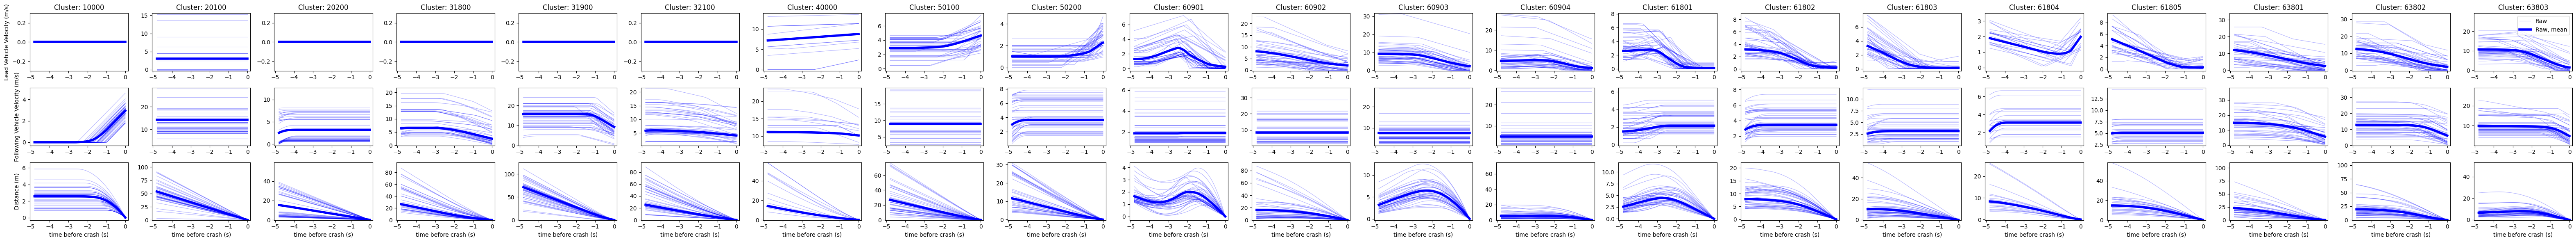

In [13]:
clsInspection(
    X,
    y_updated,
    Weight,
    dimen=3,
#     cluster_selection = list(np.unique(y_updated)[1:]),
    traj_number = 40,
    normalized_results = False,
    line_transparency = 0.3,
    line_width = 0.8,
    line_width_ratio = 5,
    fig_name=None)

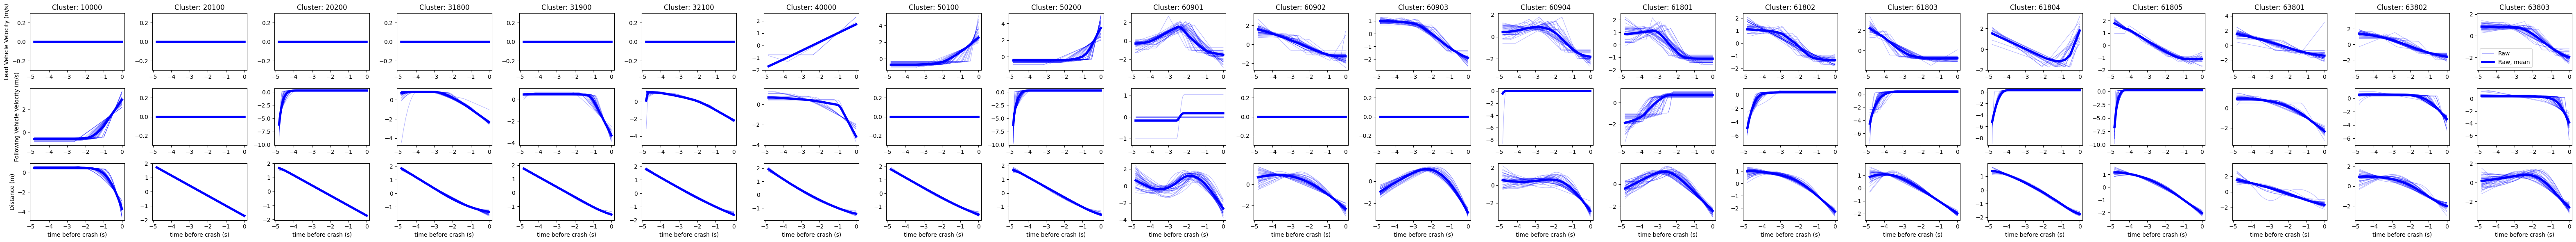

In [14]:
clsInspection(
    X,
    y_updated,
    Weight,
    dimen=3,
#     cluster_selection = list(np.unique(y_updated)[1:]),
    traj_number = 40,
    normalized_results = True,
    line_transparency = 0.3,
    line_width = 0.8,
    line_width_ratio = 5,
    fig_name=None)

# Distribution Check

## split dataset

In [15]:
def split_based_on_labels(y,weights,split_size = 0.5):
    '''
    Split the dataset to make sure each label has the same weight proportion
    '''
    idxes_splited = []
    labels = np.unique(y)
    for label in labels:
        times = 0
        # print(label)
        idxes_cls = np.arange(y.shape[0])[y==label]
        while True:
            times += 1
            # print(times)
            if times>10000:
                print(label)
                raise ValueError("couldn't split")
            # np.random.shuffle(idxes_cls)
            idxes_cls = np.random.permutation(idxes_cls)
            weights_cls = weights[idxes_cls]
            weights_cls_sum = np.sum(weights_cls)
            weights_cls_cumsum = np.cumsum(weights_cls)
            weights_cls_cumsum -= split_size*weights_cls_sum

            # Initialize variables to store the closest value and its index
            closest_index = 0
            closest_value = weights_cls_cumsum[0]
            # Iterate through the array to find the closest value to 0
            for i in range(1, len(weights_cls_cumsum)):
                if abs(weights_cls_cumsum[i]) < abs(closest_value):
                    closest_value = weights_cls_cumsum[i]
                    closest_index = i

            ## if the weight value is within a threshold, store
            if abs(closest_value)<=1 and closest_index>0 and closest_index<idxes_cls.shape[0]-1:
                idxes_cls_splited = idxes_cls[:closest_index+1]
                break
#             elif label == 40000:
#             # elif label == 400000000:
#                 if abs(closest_value)<=1 and closest_index>0 and closest_index<idxes_cls.shape[0]-1:
#                     idxes_cls_splited = idxes_cls[:closest_index+1]
#                     print(idxes_cls_splited, idxes_cls[closest_index+1:])
#                     break
# #                 else:
# #                     print(weights_cls_cumsum)

        idxes_splited.append(idxes_cls_splited)

    idxes_splited = np.array([item for sublist in idxes_splited for item in sublist])
    return idxes_splited

## check distribution

In [ ]:
from utils_evaluation import weighted_ks_2samp

In [ ]:
def mean_error_trainvaltest(kinematic, weight, Idx_train, Idx_val, Idx_test):
    mean_train = np.average(kinematic[Idx_train],axis = 0, weights=weight[Idx_train])
    mean_val = np.average(kinematic[Idx_val],axis = 0, weights=weight[Idx_val])
    mean_test = np.average(kinematic[Idx_test],axis = 0, weights=weight[Idx_test])

    error1 = np.linalg.norm(mean_train - mean_val)
    error2 = np.linalg.norm(mean_train - mean_test)
    error3 = np.linalg.norm(mean_val - mean_test)
    return error1, error2, error3, mean_train, mean_val, mean_test

def distribution_check(V_l, V_f, D, weight, Idx_trainval, Idx_test):

    Kine = [V_l[:,-1], V_f[:,-1] - V_l[:,-1], (V_l[:,-1] - V_l[:,-2])/0.05, (V_f[:,-1] - V_f[:,-2])/0.05] ## v_l, v_f-v_l, a_l, a_f
    for t in range(0,97,10):
        Kine.append(V_l[:,t])
        Kine.append(V_f[:,t])
        Kine.append(D[:,t])
        Kine.append((V_l[:,t] - V_l[:,t-1])/0.05)
        Kine.append((V_l[:,t] - V_l[:,t-1])/0.05)

    for kine in Kine:
        ks_stat, ks_p = weighted_ks_2samp(kine[Idx_trainval],kine[Idx_test],weight[Idx_trainval],weight[Idx_test])
        if ks_p < 0.9:
            return False

    # Kine = [V_l, V_f, D]
    # for kine in Kine:
    #     error1, error2, error3, _, _, _ = mean_error_trainvaltest(kine, weight, Idx_train, Idx_val, Idx_test)
    #     if error1>5 or error2>5 or error3>20:
    #         return False

    return True

In [ ]:
idx_good = []
i_t = 0
while True:
    print(i_t)
    i_t+=1
    try:
        Idx_trainval = split_based_on_labels(y_updated, Weight, split_size = 0.05)
        Idx_test = np.array([element for element in np.arange(y_updated.shape[0]) if element not in Idx_trainval])
    except:
        continue

    ## find idxes in each clusters for train or val or test
    labels = np.unique(y_updated)
    Idxes_trainval = []
    Idxes_test = []
    for label in labels:
        Idxes_trainval.append(np.intersect1d(np.where(y_updated==label)[0], Idx_trainval))
        Idxes_test.append(np.intersect1d(np.where(y_updated==label)[0], Idx_test))

    # distribution_check(V_l, V_f, D, Weight, Idx_trainval, Idx_test)
    for idxes_trainval, idxes_test in zip(Idxes_trainval, Idxes_test):
        if ~distribution_check(V_l, V_f, D, Weight, idxes_trainval, idxes_test):
            continue
    # print(distribution_check(V_l, V_f, D, Weight, Idx_trainval, Idx_test))
    print("ok")
    idx_good.append([Idx_trainval, Idx_test])
    if len(idx_good)>=10:
        break

In [ ]:
np.unique(y_updated[idx_good[0][0]], return_counts=True)

In [ ]:
import copy
idx_feed = copy.deepcopy(idx_good)

# Clustering (dataset for feeding the behavior generation model)

In [30]:
import pickle
with open('/content/Idx_fd_smallquantity.pkl', 'rb') as f:
    idx_feed = pickle.load(f)

In [20]:
!pip install pycuda
!pip install pyopencl
!pip install GPUDTW

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.4 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1.2-cp310-cp310-linux_x86_64.whl size=662246 sha256=118f6762adef6fb19f0dafe770638fa6e1ba3659091076aaf67e219d88ce2baf
  Stored in directory: /root/.cache/pip/wheels/70/63/40/4bf006182f942d3516b71bb2ff3b57ccbdb8b2c0ee81882b6e
Successfully built pycuda
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.1/698.1 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.3/518.3 kB 30.8 MB/s eta 0:00:00


In [31]:
from GPUDTW import cuda_dtw

In [32]:
idxes_trainval = idx_feed[0][0]
idxes_test = idx_feed[0][0]

X_trainval = X[idxes_trainval]
X_test = X[idxes_test]

In [33]:
dist_matrix_trainval = hc_dm(X_trainval[:,:,1], alg="dtw")

{'Max_Grid_X': 2147483647, 'Max_Grid_Y': 65535, 'Max_Threads_pre_Block': 1024, 'Max_share_memeory_per_block': 49152, 'COMPUTE_CAPABILITY_MAJOR': 8, 'total_memory': 23802544128}
grids,block_DimX 1184902 1 3 873
Splits [0, 207]
grid_run T0,Gx,Gy,Tbits  207 69 1 0.22978591918945312


# Cluster filter parameters

#### Note: To calculate the distance threshold of each cluster, the outlier should be excluded. (i.e., go to the code that assign y value, comment this code: "mergeOutlierToOther(dist_matrix,y_updated,y_target=0)")

In [ ]:
# from tslearn.preprocessing import TimeSeriesResampler
# V_l_std_ds = TimeSeriesResampler(30).fit_transform(X[:,:97,1])[:,:,0]
# V_f_std_ds = TimeSeriesResampler(30).fit_transform(X[:,97:2*97,1])[:,:,0]
# D_std_ds = TimeSeriesResampler(30).fit_transform(X[:,2*97:,1])[:,:,0]
# X_std_ds = np.hstack((V_l_std_ds, V_f_std_ds, D_std_ds))

# dist_matrix_ds = pdist(X_std_ds, lambda u, v: fastdtw(u, v)[0])
# np.save('hc_dm_ds.npy', dist_matrix_ds)

In [ ]:
# dist_matrix_ds = np.load('hc_dm_ds.npy')

In [ ]:
from scipy.optimize import minimize
import scipy.stats as stats
import seaborn as sns

def fit_datapoints_weibull(data,weights,threshold = 0.97,
                           fig = True,
                           shape = 1, scale = 1,
                           title = "CDF of min distance", xlabel = "Distance", ylabel = "Percentage"):

    # Define the weighted negative log-likelihood function for the Weibull distribution
    def weibull_neg_log_likelihood(params, data, weights):
        shape, scale = params
        # Ensure shape and scale parameters are positive
        if shape <= 0 or scale <= 0:
            return np.inf
        # Compute the log-likelihood
        log_likelihood = (weights * (np.log(shape) - shape * np.log(scale) + (shape - 1) * np.log(data) - (data / scale) ** shape)).sum()
        return -log_likelihood  # Negative because we will minimize

    # Initial guesses for the shape and scale parameters
    initial_guess = [shape, scale]

    # Minimize the negative log-likelihood function
    result = minimize(weibull_neg_log_likelihood, initial_guess, args=(data, weights), method='L-BFGS-B', bounds=[(0, None), (0, None)])

    # Extract the fitted shape and scale parameters
    shape, scale = result.x

    # Generate values from the fitted distribution
    x = np.linspace(min(data), max(data), 100)
    # fitted_pdf = (shape / scale) * (x / scale) ** (shape - 1) * np.exp(-(x / scale) ** shape)
    fitted_cdf = 1 - np.exp(-(x / scale) ** shape)

    # Create the Weibull distribution object with the fitted parameters
    weibull_dist = stats.weibull_min(shape, scale=scale)
    # Calculate the value when CDF = 0.97
    value_at_cdf_threshold = weibull_dist.ppf(threshold)
    print(f"Value when CDF = {threshold}: {value_at_cdf_threshold}")

    ## plotting
    if fig:
        plt.figure(figsize=(4, 3.2))
        df_data = pd.DataFrame({
            'Data': data,
            'Weight': weights,
        })
        df_data.reset_index(inplace=True,drop=True)
        sns.histplot(
            data=df_data, x="Data", label='Raw',
            weights='Weight', bins=150, kde=False,
            log_scale=False, element="step", fill=False,
            cumulative=True, stat="density", common_norm=False,
        )
        # sns.histplot(datapoints, kde=False, label='Histogram', fill=False,cumulative=True,log_scale=False)
        sns.lineplot(x=x, y=fitted_cdf, color='red', linewidth=1.5, label='Weibull')

        ## draw the threshold line
        plt.axvline(
            x=value_at_cdf_threshold,
            color='green', linestyle='--', linewidth=1.5,
            label=f'{threshold*100}% threshold \n (={round(value_at_cdf_threshold,2)})'
        )

        plt.ylim([-0.01,1.01])

        # Add labels and title
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()

        # Show plot
        plt.show()
    return value_at_cdf_threshold, shape, scale

In [ ]:
def calculate_distance_threshold(dist_matrix,label):

    dm_sqr = squareform(dist_matrix)
    dm_sqr_target = dm_sqr[y_updated==label][:,y_updated==label]

    dm_sqr_target_masked = np.where(dm_sqr_target>1e-1, dm_sqr_target, np.inf)
    min_values = np.min(dm_sqr_target_masked, axis=1)

    return min_values

In [ ]:
dist_matrix = np.load('.\\utils_data\\hc_dtw_dm_rawraw.npy')

Value when CDF = 0.97: 1.5601198441692672
Value when CDF = 0.97: 0.41122210100579387
Value when CDF = 0.97: 0.4112221007077239
Value when CDF = 0.97: 0.4112221008406689


C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_a

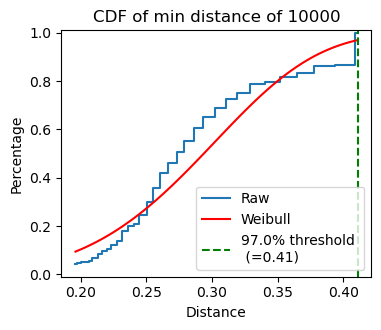

Value when CDF = 0.97: 3.506557897319981
Value when CDF = 0.97: 3.506557897319981
Value when CDF = 0.97: 3.506557897319981


C:\Users\minxiang\AppData\Local\Temp\ipykernel_14872\3826941108.py:17: RuntimeWarning: invalid value encountered in multiply
  log_likelihood = (weights * (np.log(shape) - shape * np.log(scale) + (shape - 1) * np.log(data) - (data / scale) ** shape)).sum()
C:\Users\minxiang\AppData\Local\Temp\ipykernel_14872\3826941108.py:17: RuntimeWarning: invalid value encountered in subtract
  log_likelihood = (weights * (np.log(shape) - shape * np.log(scale) + (shape - 1) * np.log(data) - (data / scale) ** shape)).sum()
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\numpy\core\function_base.py:139: RuntimeWarning: invalid value encountered in scalar subtract
  delta = stop - start
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\

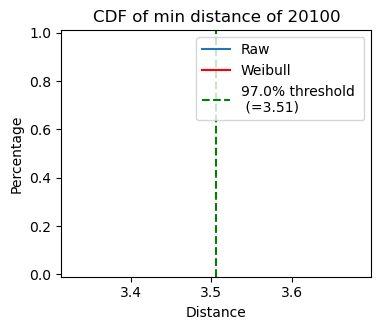

Value when CDF = 0.97: 1.867991915727616
Value when CDF = 0.97: 0.6128249519827884
Value when CDF = 0.97: 0.5908914349843173
Value when CDF = 0.97: 0.5408273057423891


C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_a

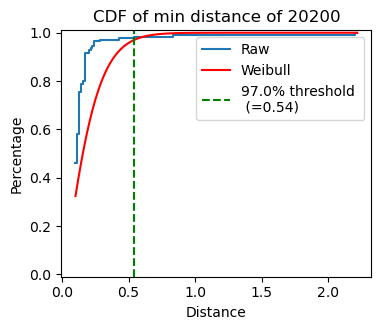

Value when CDF = 0.97: 1.7345507870892667
Value when CDF = 0.97: 0.6449402914301444
Value when CDF = 0.97: 0.3448367155230986
Value when CDF = 0.97: 0.23483005792082234
Value when CDF = 0.97: 0.23483005792082234
Value when CDF = 0.97: 0.23483005792082234


C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_a

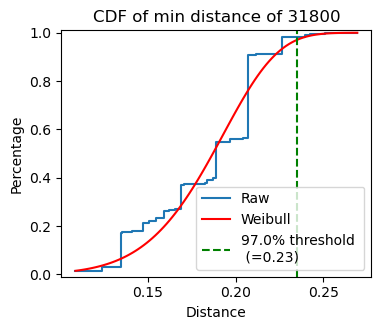

Value when CDF = 0.97: 1.83389974717049
Value when CDF = 0.97: 0.5875352297845047
Value when CDF = 0.97: 0.5875352297845047
Value when CDF = 0.97: 0.5875352297845047


C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_a

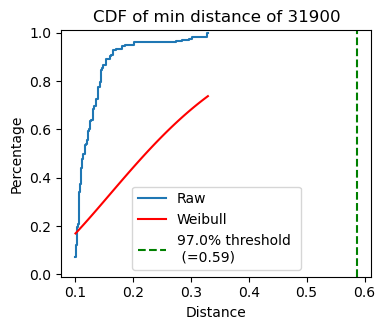

Value when CDF = 0.97: 1.7963143661384093
Value when CDF = 0.97: 0.6093519061831429
Value when CDF = 0.97: 0.3471002771383499
Value when CDF = 0.97: 0.23001825399601444
Value when CDF = 0.97: 0.2300182508564486
Value when CDF = 0.97: 0.23001824915018276


C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_a

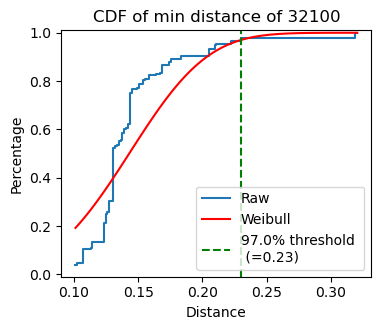

Value when CDF = 0.97: 5.45065314193438
Value when CDF = 0.97: 5.45065314193438
Value when CDF = 0.97: 5.45065314193438


C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


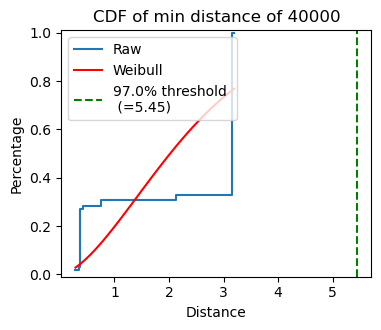

Value when CDF = 0.97: 1.7234430421592497
Value when CDF = 0.97: 0.7411691606449027
Value when CDF = 0.97: 0.5232795332116352
Value when CDF = 0.97: 0.5232795480322968
Value when CDF = 0.97: 0.5232795480322968


C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_a

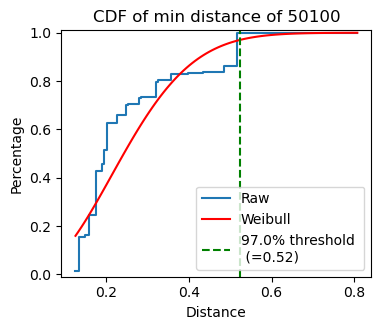

Value when CDF = 0.97: 1.2295674828164393
Value when CDF = 0.97: 1.229567708915674
Value when CDF = 0.97: 1.2295675700968858


C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


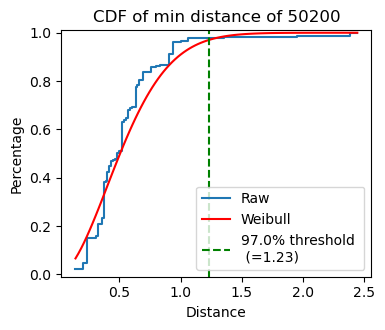

Value when CDF = 0.97: 1.7022312859402358
Value when CDF = 0.97: 1.7022312859402358
Value when CDF = 0.97: 1.7022312859402358


C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


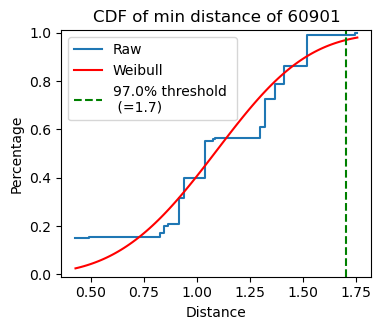

Value when CDF = 0.97: 1.4316011704592333
Value when CDF = 0.97: 1.233218163576643
Value when CDF = 0.97: 0.8570642747300176
Value when CDF = 0.97: 0.8570642762973126
Value when CDF = 0.97: 0.8570642762973126


C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_a

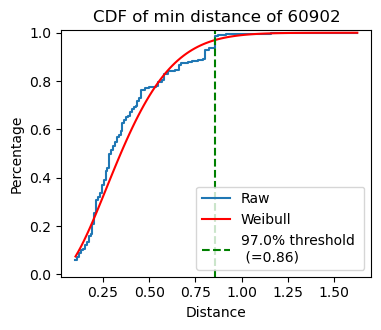

Value when CDF = 0.97: 0.7786292079020132
Value when CDF = 0.97: 0.7786290482936321
Value when CDF = 0.97: 0.7786290482936321


C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


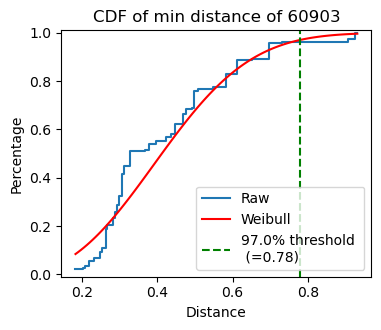

Value when CDF = 0.97: 1.5149951023587662
Value when CDF = 0.97: 1.514995516613619
Value when CDF = 0.97: 1.514995516613619


C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


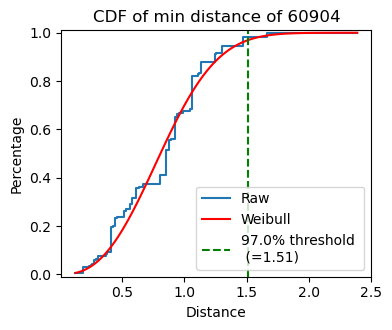

Value when CDF = 0.97: 1.4068579562039558
Value when CDF = 0.97: 1.406857982568608
Value when CDF = 0.97: 1.406857982568608


C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


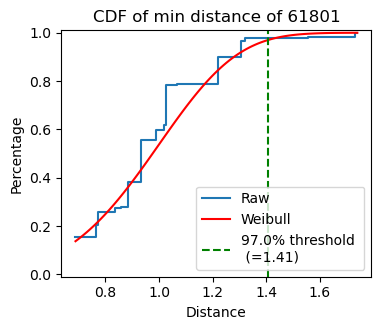

Value when CDF = 0.97: 1.2560095135600473
Value when CDF = 0.97: 1.2560095135600473
Value when CDF = 0.97: 1.2560095135600473


C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


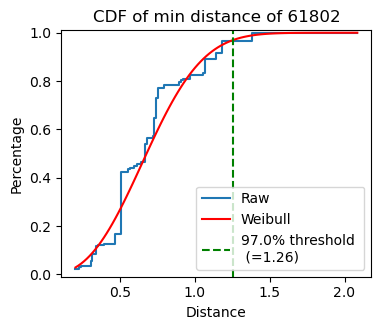

Value when CDF = 0.97: 1.2783244946880874
Value when CDF = 0.97: 1.278324190637601
Value when CDF = 0.97: 1.278324509986621


C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


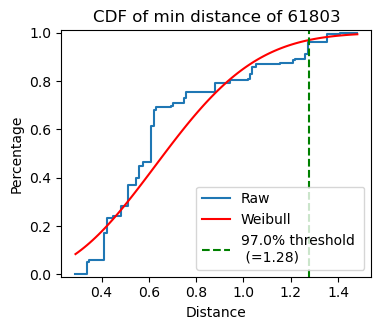

Value when CDF = 0.97: 1.7972113287719205
Value when CDF = 0.97: 1.3059814519596515
Value when CDF = 0.97: 1.1176835420209372
Value when CDF = 0.97: 1.1176835420209372
Value when CDF = 0.97: 1.1176835420209372


C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_a

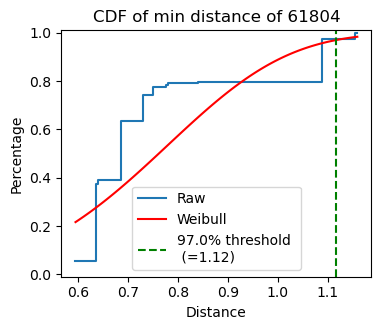

Value when CDF = 0.97: 1.7446947874369159
Value when CDF = 0.97: 1.7446947874369159
Value when CDF = 0.97: 1.7446947874369159


C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


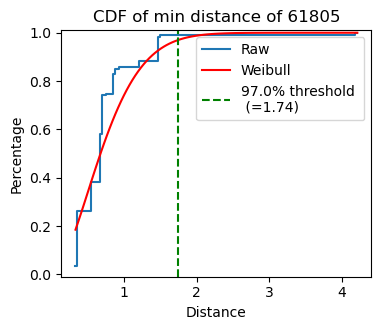

Value when CDF = 0.97: 0.950007738769841
Value when CDF = 0.97: 0.9500077824933606
Value when CDF = 0.97: 0.950007754012248


C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_a

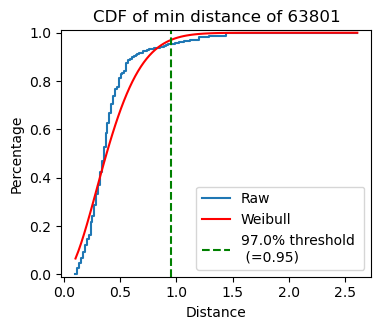

Value when CDF = 0.97: 0.9727257928120068
Value when CDF = 0.97: 0.972725790614034
Value when CDF = 0.97: 0.9727257906140332


C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


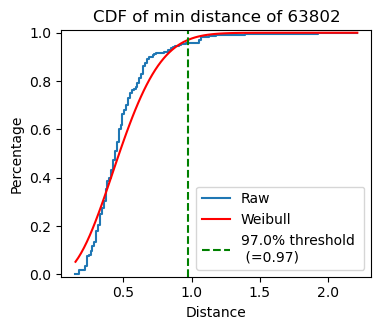

Value when CDF = 0.97: 1.3209738799124005
Value when CDF = 0.97: 1.3209739019713937
Value when CDF = 0.97: 1.3209739019713937


C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\minxiang\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


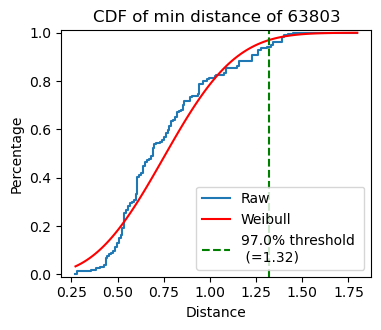

In [ ]:
labels = np.unique(y_updated)
dist_thresholds = []

# for label in labels[3:]:
for label in labels[1:]:

    min_values = calculate_distance_threshold(dist_matrix,label)

    dist_threshold_old, shape, scale = fit_datapoints_weibull(
        min_values, Weight[y_updated==label],threshold = 0.97,
        fig = False,
        title = f"CDF of min distance of {label}"
    )
    dist_threshold_new, shape, scale = fit_datapoints_weibull(
        min_values, Weight[y_updated==label],threshold = 0.97,
        fig = False,
        shape = shape, scale = scale,
        title = f"CDF of min distance of {label}"
    )
    if abs(dist_threshold_new-dist_threshold_old)>0.1:
        while abs(dist_threshold_new-dist_threshold_old)>0.1:
            dist_threshold_old = dist_threshold_new
            dist_threshold_new, shape, scale = fit_datapoints_weibull(
                min_values, Weight[y_updated==label],threshold = 0.97,
                fig = False,
                shape = shape, scale = scale,
                title = f"CDF of min distance of {label}"
            )

    dist_threshold, _, _ = fit_datapoints_weibull(
        min_values, Weight[y_updated==label],threshold = 0.97,
        fig = True,
        shape = shape, scale = scale,
        title = f"CDF of min distance of {label}"
    )
    dist_thresholds.append(dist_threshold)

In [ ]:
# label = labels[1] # Cluster 10000

# min_values = calculate_distance_threshold(dist_matrix,label)

# dist_threshold = fit_datapoints_weibull(
#     min_values, Weight[y_updated==label],threshold = 0.97,
#     fig = True,
#     title = f"CDF of min distance of {label}"
# )

In [ ]:
# ## add distance threshold for Cluster 10000
# dist_thresholds.insert(0, dist_threshold)

# ## add distance threshold for Cluster 20100
# dist_thresholds.insert(1, 1e-3)

In [ ]:
# dist_thresholds[-2] = 1e-1
dist_thresholds[1] = 1e-1

In [ ]:
print(dist_thresholds)
dist_thresholds = np.array(dist_thresholds)
np.save('.\\utils_data\\hc_olddtw_dist_thres.npy', dist_thresholds)

[0.4112221008406689, 0.1, 0.5408273057423891, 0.23483005792082234, 0.5875352297845047, 0.23001824915018276, 5.45065314193438, 0.5232795480322968, 1.2295675700968858, 1.7022312859402358, 0.8570642762973126, 0.7786290482936321, 1.514995516613619, 1.406857982568608, 1.2560095135600473, 1.278324509986621, 1.1176835420209372, 1.7446947874369159, 0.950007754012248, 0.9727257906140332, 1.3209739019713937]


In [ ]:
# import numpy as np
# from scipy.optimize import minimize
# import matplotlib.pyplot as plt

# # Define the weighted negative log-likelihood function for the Weibull distribution
# def weibull_neg_log_likelihood(params, data, weights):
#     shape, scale = params
#     # Ensure shape and scale parameters are positive
#     if shape <= 0 or scale <= 0:
#         return np.inf
#     # Compute the log-likelihood
#     log_likelihood = (weights * (np.log(shape) - shape * np.log(scale) + (shape - 1) * np.log(data) - (data / scale) ** shape)).sum()
#     return -log_likelihood  # Negative because we will minimize

# # Example data points and their weights
# # data = np.array([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])
# data = min_values
# # weights = np.array([1, 2, 1, 1, 2, 1, 1])
# weights = Weight[y_updated==label]

# # Initial guesses for the shape and scale parameters
# initial_guess = [1.0, 1.0]

# # Minimize the negative log-likelihood function
# result = minimize(weibull_neg_log_likelihood, initial_guess, args=(data, weights), method='L-BFGS-B', bounds=[(0, None), (0, None)])

# # Extract the fitted shape and scale parameters
# shape, scale = result.x

# print(f"Fitted Shape: {shape}, Fitted Scale: {scale}")

# # Generate values from the fitted distribution
# x = np.linspace(min(data), max(data), 100)
# # x = np.linspace(0, max(data), 100)
# fitted_pdf = (shape / scale) * (x / scale) ** (shape - 1) * np.exp(-(x / scale) ** shape)
# fitted_cdf = 1 - np.exp(-(x / scale) ** shape)

# # Plot the histogram of the data and the fitted PDF
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.hist(data, bins=20, density=True, alpha=0.6, color='g', weights=weights, label='Weighted Data')
# plt.plot(x, fitted_pdf, 'r-', lw=2, label='Fitted Weibull PDF')
# plt.xlabel('Data')
# plt.ylabel('Density')
# plt.title('PDF')
# plt.legend()

# # Plot the CDF
# plt.subplot(1, 2, 2)
# plt.plot(x, fitted_cdf, 'r-', lw=2, label='Fitted Weibull CDF')
# plt.xlabel('Data')
# plt.ylabel('Cumulative Probability')
# plt.title('CDF')
# plt.legend()

# plt.tight_layout()
# plt.show()

# # Create the Weibull distribution object with the fitted parameters
# weibull_dist = stats.weibull_min(shape, scale=scale)

# # Calculate the value when CDF = 0.97
# value_at_cdf_97 = weibull_dist.ppf(0.97)

# print(f"Value when CDF = 0.97: {value_at_cdf_97}")

In [ ]:
# import numpy as np
# import scipy.stats as stats
# import scipy.optimize as optimize
# import matplotlib.pyplot as plt

# # Example data points and their corresponding weights
# # data_points = np.array([1.5, 2.3, 3.1, 4.7, 2.9, 3.6])  # Replace with your actual data points
# data_points = min_values
# # weights = np.array([2, 1, 3, 1, 2, 1])  # Replace with your actual weights
# weights = Weight[y_updated==label]

# # Define the negative log-likelihood function for the lognormal distribution
# def neg_log_likelihood(params, data, weights):
#     shape, loc, scale = params
#     # Calculate the log-probability density function for the lognormal distribution
#     log_pdf = stats.lognorm.logpdf(data, s=shape, loc=loc, scale=scale)
#     # Weighted negative log-likelihood
#     nll = -np.sum(weights * log_pdf)
#     return nll

# # Initial guesses for shape, loc, and scale
# initial_params = [1, 0, 1]

# # Optimize the parameters to minimize the negative log-likelihood
# result = optimize.minimize(neg_log_likelihood, initial_params, args=(data_points, weights), method='L-BFGS-B', bounds=[(0, None), (0, None), (0, None)])
# shape, loc, scale = result.x

# # Create an array of values for the x-axis (for plotting the PDF)
# x = np.linspace(min(data_points), max(data_points), 1000)

# # Calculate the PDF of the fitted lognormal distribution
# pdf_fitted = stats.lognorm.pdf(x, shape, loc, scale)

# # Plot the histogram of the weighted data and the PDF of the fitted distribution
# plt.hist(data_points, bins=30, weights=weights, density=True, alpha=0.6, color='g', label='Weighted data histogram')
# plt.plot(x, pdf_fitted, 'r-', lw=2, label='Fitted lognormal PDF')
# plt.xlabel('Data')
# plt.ylabel('Density')
# plt.legend()
# plt.show()

# # Print the fitted parameters
# print(f"Fitted parameters: shape={shape}, loc={loc}, scale={scale}")


# Cluster Visual Check

In [52]:
dist_matrix_hc = np.copy(dist_matrix_trainval)
X_hc = np.copy(X_trainval)
dist_matrix_hc = np.copy(dist_matrix_trainval)
Weight_hc = np.copy(Weight[idxes_trainval])

First Clustering

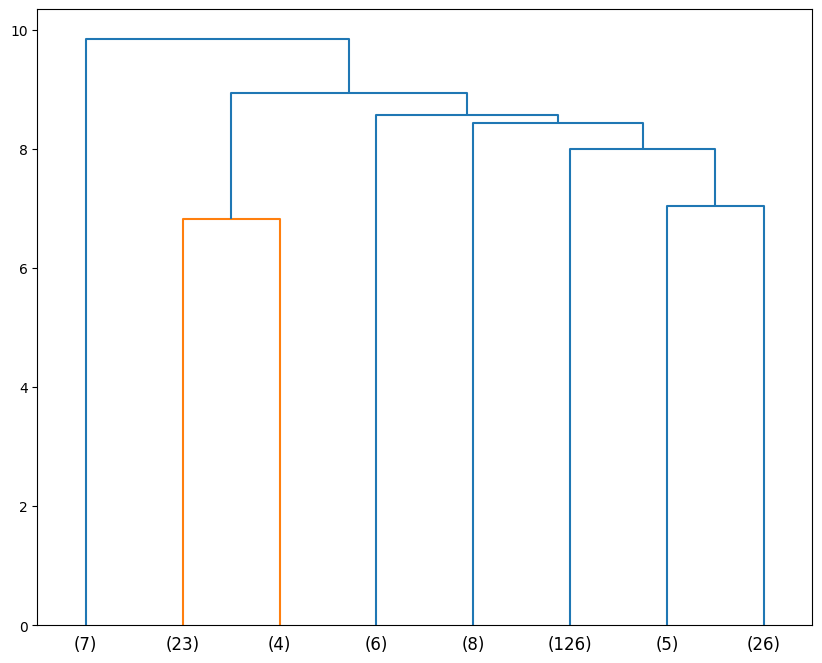

(array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int32),
 array([  7,  23,   4,   6,   8, 126,   5,  26]))

In [53]:
n_clusters = 8
y_hc = hc_fcluster(dist_matrix_hc, method='single', n_cls=n_clusters, figsize=(10,8))
y_hc = filterOutlier(y_hc)
np.unique(y_hc,return_counts=True)

In [ ]:
# mergeOutlierToOther(dist_matrix,y,y_target=0)
# np.unique(y,return_counts=True)

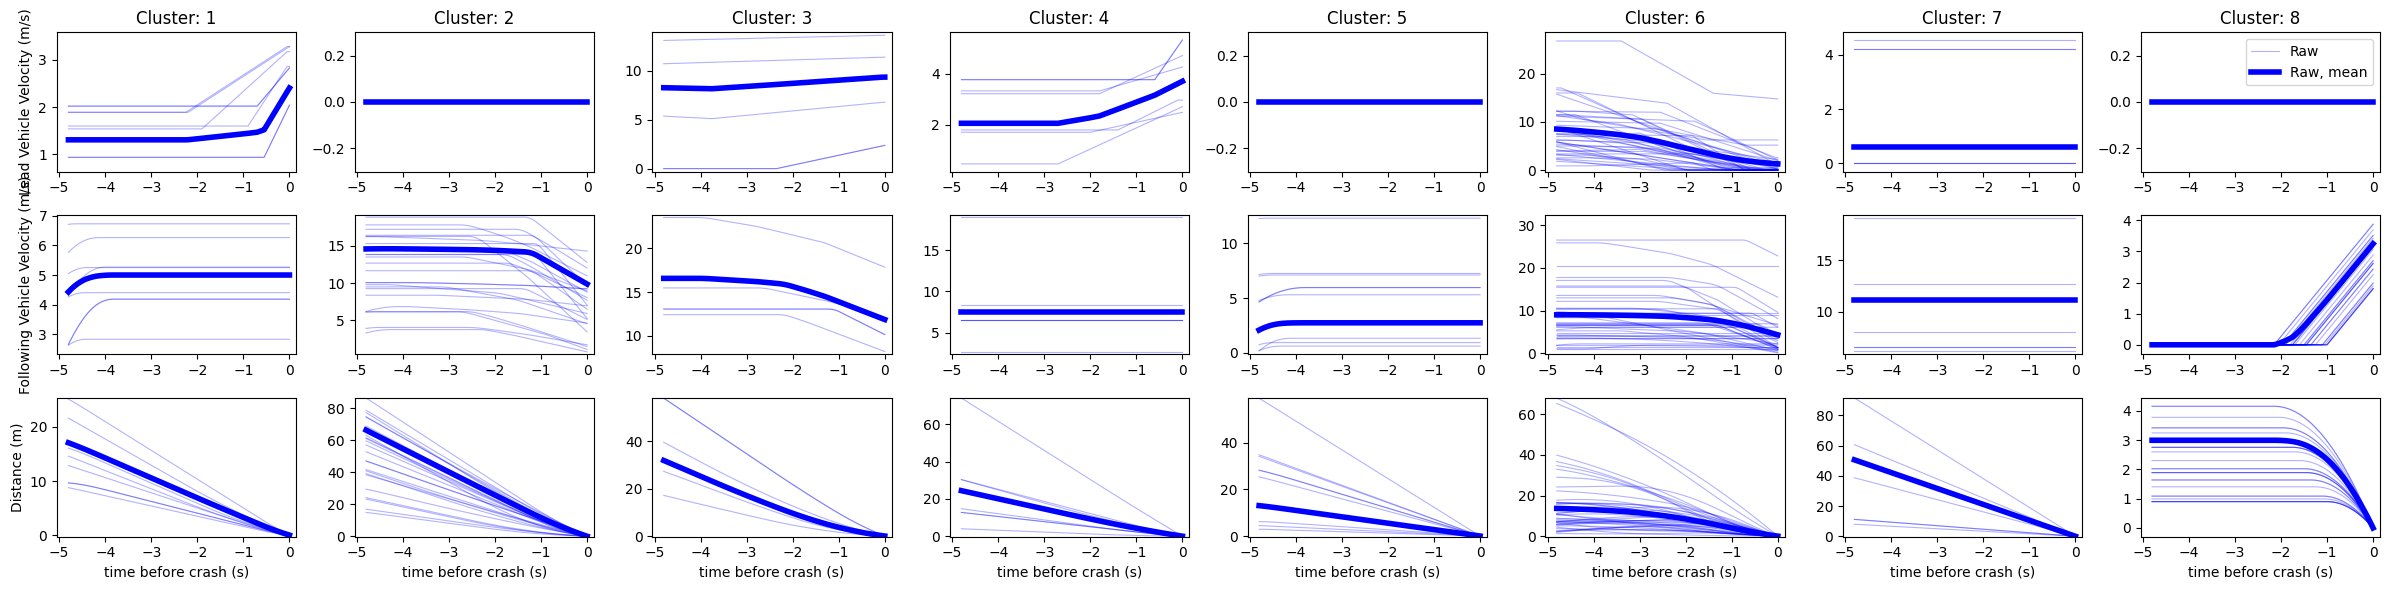

In [54]:
clsInspection(
    X_hc,
    y_hc,
    Weight_hc,
    dimen=3,
#     cluster_selection = list(np.unique(y)[1:]),
    traj_number = 40,
    line_transparency = 0.3,
    line_width = 0.8,
    line_width_ratio = 5,
    fig_name=None)

Second Clustering y=2

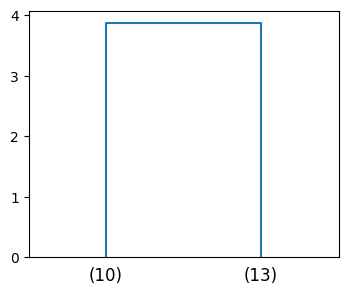

(array([1, 2], dtype=int32), array([10, 13]))

In [74]:
y_target = 2
dm_squareform = squareform(dist_matrix_hc)
dm_sec = dm_squareform[y_hc==y_target][:,y_hc==y_target]
dm_sec = squareform(dm_sec)
y_sec = hc_fcluster(dm_sec, method='complete', n_cls=2, figsize=(4, 3.2))
np.unique(y_sec,return_counts=True)

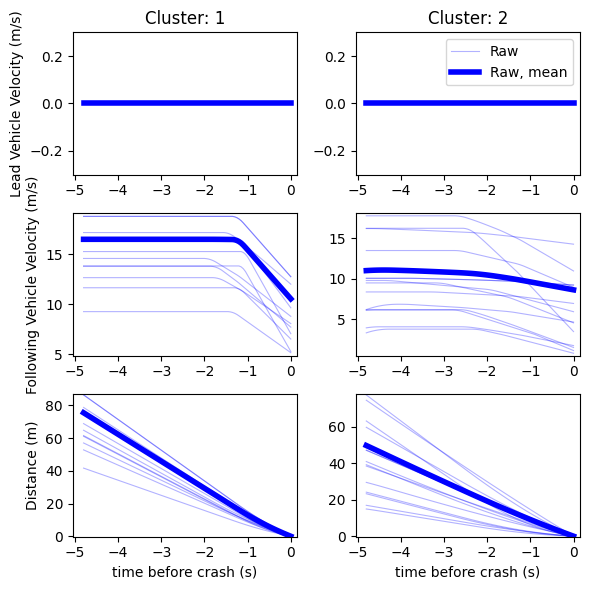

In [75]:
clsInspection(
    X_hc[y_hc==y_target],
    y_sec,
    Weight_hc[y_hc==y_target],
    dimen=3,
    # cluster_selection = list(np.unique(y_sec)[1:]),
    cluster_selection = None,
    traj_number = 40,
    line_transparency = 0.3,
    line_width = 0.8,
    line_width_ratio = 5,
    fig_name=None)

Second Clustering y=6

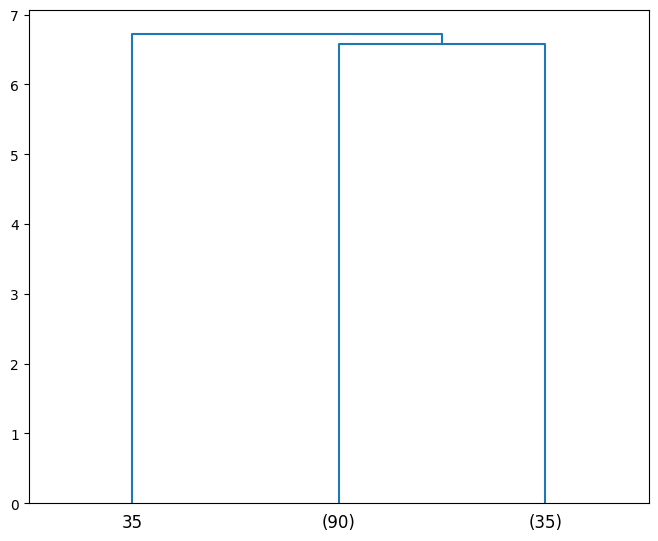

(array([1, 2, 3], dtype=int32), array([90, 35,  1]))

In [78]:
y_target = 6
dm_squareform = squareform(dist_matrix_hc)
dm_sec = dm_squareform[y_hc==y_target][:,y_hc==y_target]
dm_sec = squareform(dm_sec)
y_sec = hc_fcluster(dm_sec, method='single', n_cls=3, figsize=(8, 6.4))
np.unique(y_sec,return_counts=True)

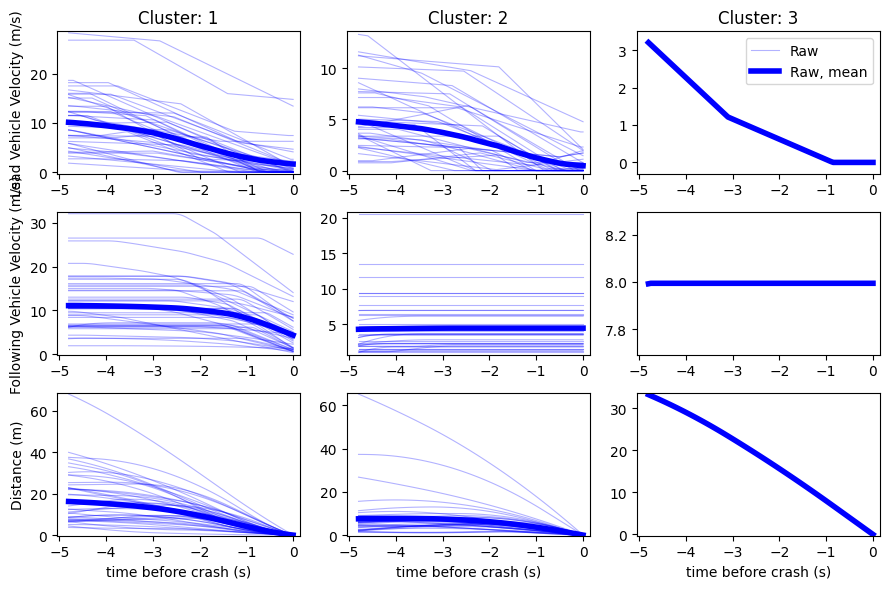

In [79]:
clsInspection(
    X_hc[y_hc==y_target],
    y_sec,
    Weight_hc[y_hc==y_target],
    dimen=3,
    # cluster_selection = list(np.unique(y_sec)[1:]),
    cluster_selection = None,
    traj_number = 40,
    line_transparency = 0.3,
    line_width = 0.8,
    line_width_ratio = 5,
    fig_name=None)

Second Clustering y=6.1

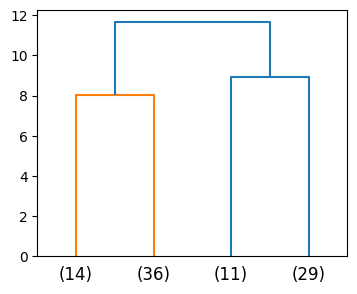

In [93]:
y_target = 6
y_sec_target = 1
dm_squareform = squareform(dist_matrix_hc)
dm_sec_sec = dm_squareform[y_hc==y_target][:,y_hc==y_target][y_sec==y_sec_target][:,y_sec==y_sec_target]
dm_sec_sec = squareform(dm_sec_sec)
y_sec_sec = hc_fcluster(dm_sec_sec, method='complete', n_cls=4, figsize=(4, 3.2))

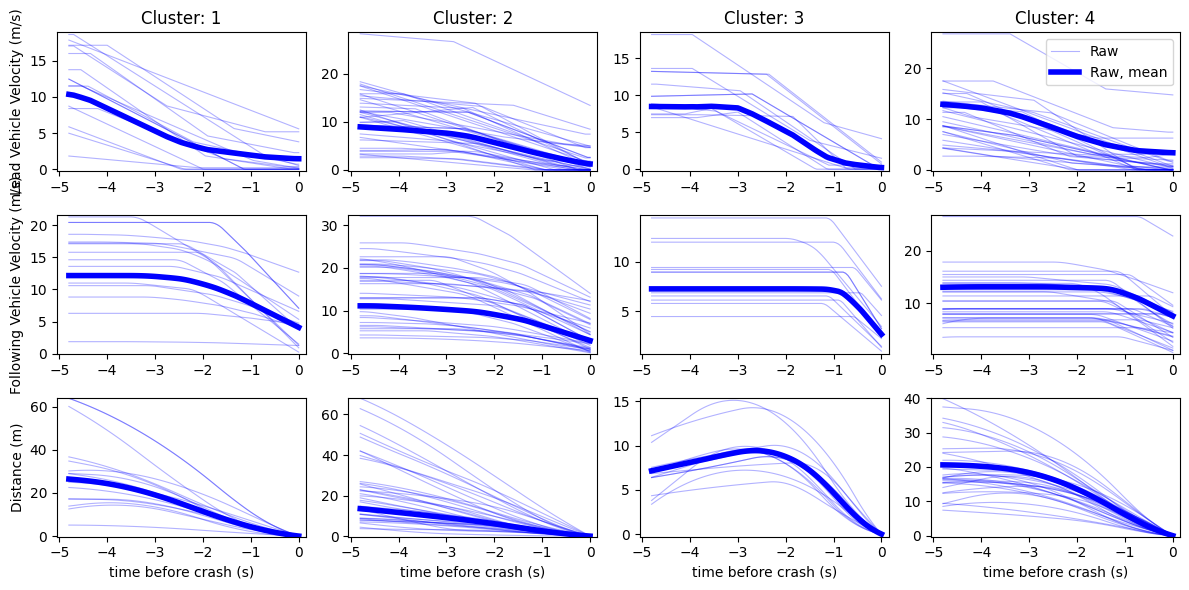

In [94]:
# y_sec = filterOutlier(y_sec,threshold=5)
clsInspection(
    X_hc[y_hc==y_target][y_sec==y_sec_target],
    y_sec_sec,
    Weight_hc[y_hc==y_target][y_sec==y_sec_target],
    dimen=3,
    # cluster_selection = list(np.unique(y_sec)[1:]),
    cluster_selection = None,
    traj_number = 40,
    line_transparency = 0.3,
    line_width = 0.8,
    line_width_ratio = 5,
    fig_name=None)

Second Clustering y=6.1.2

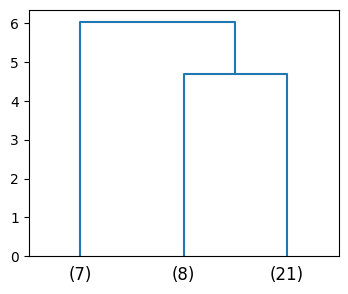

In [97]:
y_target = 6
y_sec_target = 1
y_sec_sec_target = 2
dm_squareform = squareform(dist_matrix_hc)
dm_sec_sec_sec = dm_squareform[y_hc==y_target][:,y_hc==y_target][y_sec==y_sec_target][:,y_sec==y_sec_target][y_sec_sec==y_sec_sec_target][:,y_sec_sec==y_sec_sec_target]
dm_sec_sec_sec = squareform(dm_sec_sec_sec)
y_sec_sec_sec = hc_fcluster(dm_sec_sec_sec, method='complete', n_cls=3, figsize=(4, 3.2))

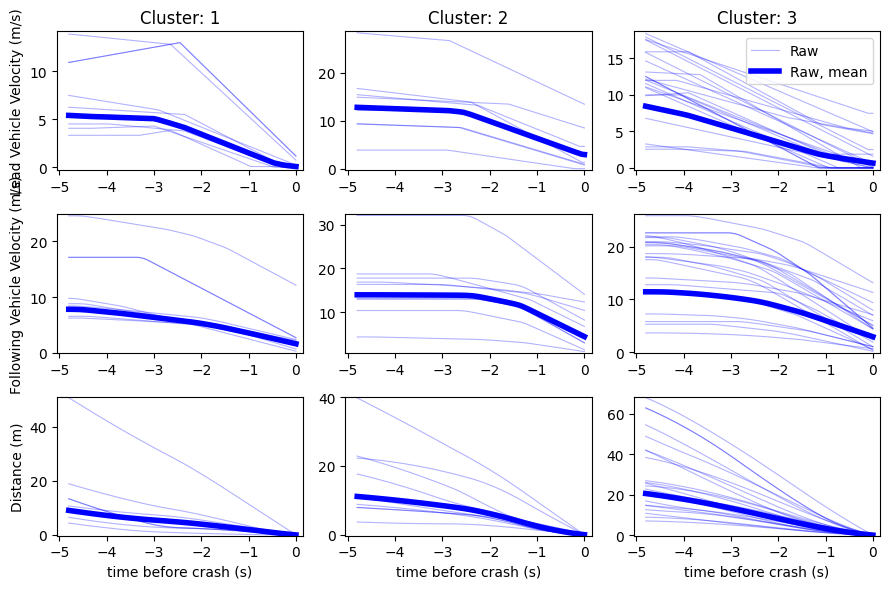

In [98]:
# y_sec = filterOutlier(y_sec,threshold=5)
clsInspection(
    X_hc[y_hc==y_target][y_sec==y_sec_target][y_sec_sec==y_sec_sec_target],
    y_sec_sec_sec,
    Weight_hc[y_hc==y_target][y_sec==y_sec_target][y_sec_sec==y_sec_sec_target],
    dimen=3,
    # cluster_selection = list(np.unique(y_sec)[1:]),
    cluster_selection = None,
    traj_number = 40,
    line_transparency = 0.3,
    line_width = 0.8,
    line_width_ratio = 5,
    fig_name=None)

Second Clustering y=6.1.4

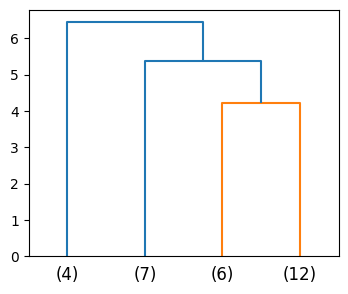

In [103]:
y_target = 6
y_sec_target = 1
y_sec_sec_target = 4
dm_squareform = squareform(dist_matrix_hc)
dm_sec_sec_sec = dm_squareform[y_hc==y_target][:,y_hc==y_target][y_sec==y_sec_target][:,y_sec==y_sec_target][y_sec_sec==y_sec_sec_target][:,y_sec_sec==y_sec_sec_target]
dm_sec_sec_sec = squareform(dm_sec_sec_sec)
y_sec_sec_sec = hc_fcluster(dm_sec_sec_sec, method='complete', n_cls=4, figsize=(4, 3.2))

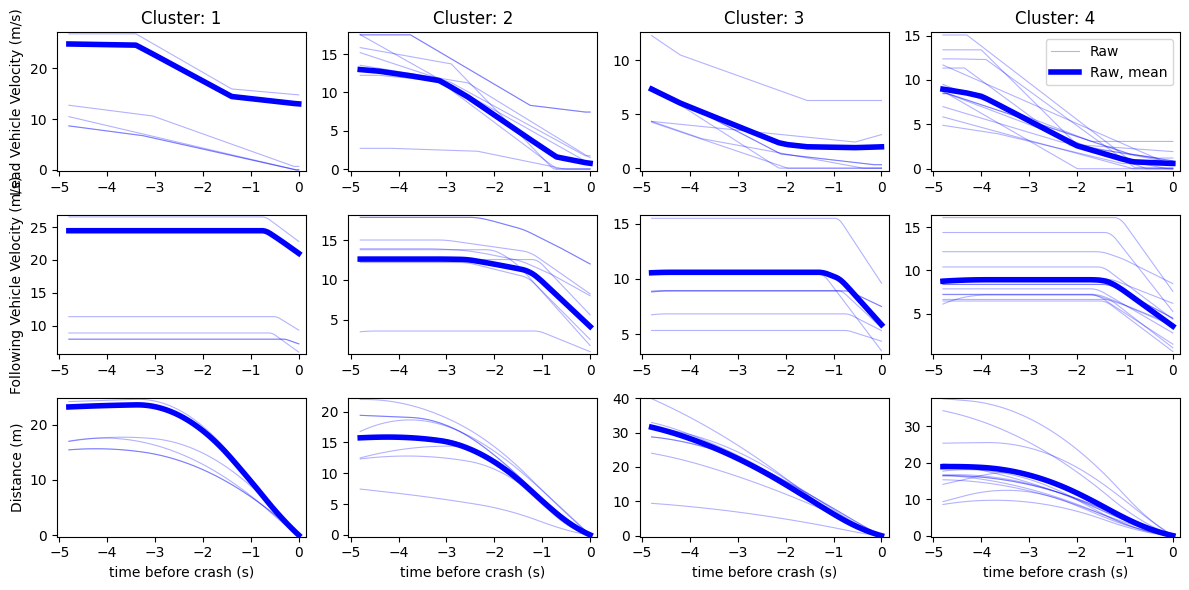

In [104]:
# y_sec = filterOutlier(y_sec,threshold=5)
clsInspection(
    X_hc[y_hc==y_target][y_sec==y_sec_target][y_sec_sec==y_sec_sec_target],
    y_sec_sec_sec,
    Weight_hc[y_hc==y_target][y_sec==y_sec_target][y_sec_sec==y_sec_sec_target],
    dimen=3,
    # cluster_selection = list(np.unique(y_sec)[1:]),
    cluster_selection = None,
    traj_number = 40,
    line_transparency = 0.3,
    line_width = 0.8,
    line_width_ratio = 5,
    fig_name=None)

Second Clustering y=6.2

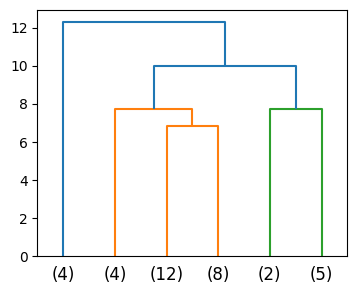

In [89]:
y_target = 6
y_sec_target = 2
dm_squareform = squareform(dist_matrix_hc)
dm_sec_sec = dm_squareform[y_hc==y_target][:,y_hc==y_target][y_sec==y_sec_target][:,y_sec==y_sec_target]
dm_sec_sec = squareform(dm_sec_sec)
y_sec_sec = hc_fcluster(dm_sec_sec, method='complete', n_cls=6, figsize=(4, 3.2))

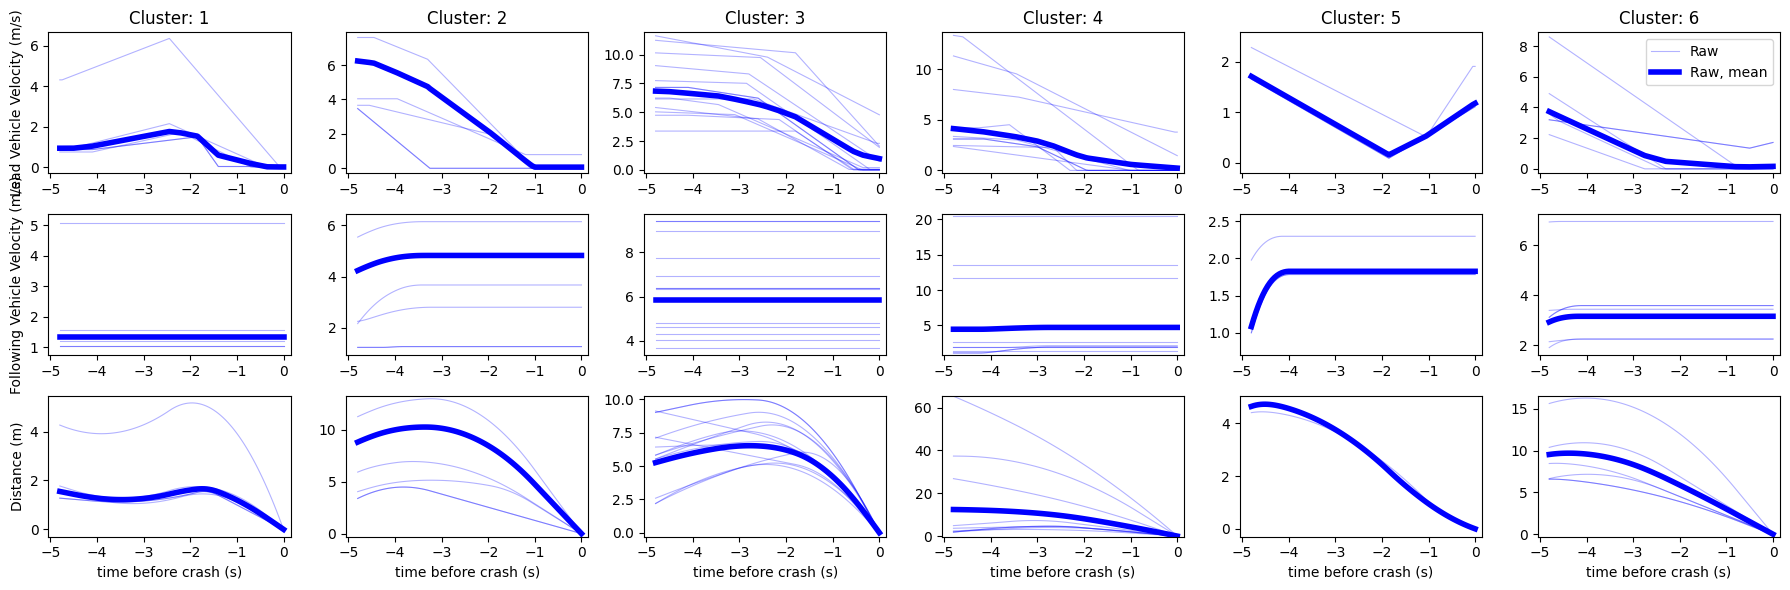

In [90]:
# y_sec = filterOutlier(y_sec,threshold=5)
clsInspection(
    X_hc[y_hc==y_target][y_sec==y_sec_target],
    y_sec_sec,
    Weight_hc[y_hc==y_target][y_sec==y_sec_target],
    dimen=3,
    # cluster_selection = list(np.unique(y_sec)[1:]),
    cluster_selection = None,
    traj_number = 40,
    line_transparency = 0.3,
    line_width = 0.8,
    line_width_ratio = 5,
    fig_name=None)